In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
from pyproj import CRS
from pathlib import Path 

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib_scalebar.scalebar import ScaleBar

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

from cartopy.feature import NaturalEarthFeature
from shapely.geometry.point import Point
from pyschism.mesh import Hgrid
from stormevents import StormEvent

In [2]:
def get_stations_coordinates(dataset):
    coord_x = dataset.longitude.values
    coord_y = dataset.latitude.values
    coord_combined = np.column_stack([coord_x, coord_y])
    return coord_combined

In [3]:
def find_stations_indices(coordinates, hgrid):
    longitude = hgrid.x.T
    latitude = hgrid.y.T
    long_lat = np.column_stack((longitude.ravel(),latitude.ravel()))
    tree = sp.spatial.cKDTree(long_lat)
    dist,idx = tree.query(coordinates,k=1)
    ind = np.column_stack(np.unravel_index(idx,longitude.shape))
    return [i for i in ind]

In [4]:
def get_schism_max_elevation(schism_output, station_indices_array):
    max_elev = []
    for idx in station_indices_array:
        tmp = float(schism_output[int(idx)].values) 
        max_elev.append(tmp)
    return max_elev

In [5]:
def get_storm_track_line(storm_track, advisory):
    for idx in storm_track.linestrings[advisory]:
        xy_line = storm_track.linestrings[advisory][idx].xy
    return xy_line

In [6]:
def find_utm_from_lon(x):
    utm_zone = int(((180+x)/6) + 1)
    return utm_zone


def utm_north_south(y):
    if y<0:
        return True
    else:
        return False
    

def get_epsg_code(utm_zone, is_south):

    epsg_dict = CRS.from_dict({'proj': 'utm', 'zone': utm_zone, 'south': is_south}).to_authority()
    return int(epsg_dict[1])


def calc_distance_meter(x, y):
    utm_zone = find_utm_from_lon(x)
    is_south = utm_north_south(y)
    proj_epsg = get_epsg_code(utm_zone,is_south)
    
    points = gpd.GeoSeries(
        [Point(x-0.5, y), 
         Point(x+0.5, y)], 
        crs=4326)  # Geographic WGS 84 - degrees
    
    points = points.to_crs(proj_epsg)  # Projected WGS 84 - meters
    distance_meters = points[0].distance(points[1])
    
    return distance_meters

In [7]:
def plot_scatter(df,storm_name,storm_year):
    figure, axis = plt.subplots(1, 1)
    
    plt.scatter(x=df['elev_m'], y=df['max_elev'], s=13, facecolors='none', edgecolors='b')
    xlim = axis.get_xlim()
    ylim = axis.get_ylim()
    ax_min = min(xlim[0],ylim[0])
    ax_max = max(xlim[1],ylim[1])
    
    axis.axline((ax_min,ax_min), (ax_max,ax_max), linestyle='--', color='grey')
    
    b, a = np.polyfit(df['elev_m'], df['max_elev'], 1)
    xline = np.linspace(ax_min+1, ax_max-1, num=10)
    axis.plot(xline, a + b * xline, color="k", lw=1);

    axis.text(0.05, 0.9, f"model = {round(a,2)} + {round(b,2)} * obs.",
              horizontalalignment='left', verticalalignment='center',
              transform=axis.transAxes, size=10)

    axis.set_xlim([ax_min, ax_max])
    axis.set_ylim([ax_min, ax_max])   
    axis.set_xlabel('USGS HWMs [m]')
    axis.set_ylabel('SCHISM max. elevation [m]')
    axis.set_title(f'{storm_name} {storm_year}')
    plt.savefig(f'{storm_name}_{storm_year}_scatter_HWM_vs_max_elev.png')

In [8]:
def plot_histogram(df,storm_name,storm_year):
    
    diff = df['max_elev'] - df['elev_m']
    min_range = round(diff.min())
    max_range = round(diff.max())+1
    bins = np.arange(min_range, max_range) 
    
    plt.hist(x=diff,
             bins=bins,
             edgecolor='black', 
             color = 'dodgerblue',
             linewidth=1.1,
             rwidth=1.0)
    
    # plt.grid()
    plt.title('SCHISM_elev - HWMs')
    plt.xlabel('Error [m]')
    plt.ylabel('Number of observation points')
    plt.savefig(f'{storm_name}_{storm_year}_histogram_HWM_vs_max_elev.png')

In [9]:
def plot_contour(df,schism_elev,tri,storm_track):
    figure, axis = plt.subplots(1, 1)
    figure.set_size_inches(12, 12/1.6)
    
    track_line = get_storm_track_line(storm_track, 'BEST')
    
    gdf_countries = gpd.GeoSeries(
        NaturalEarthFeature(
            category='physical', 
            scale='10m', 
            name='land',
        ).geometries(), 
        crs=4326)
    
    # Create a colormap with red for positive and white for negative values
    cmap = LinearSegmentedColormap.from_list('red_blue_colormap', ['white', 'blue', 'red'])

    step = 0.025  # m
    MinVal = 0.0 
    MaxVal = 10 # 
    levels = np.arange(MinVal, MaxVal + step, step=step)

    df.plot('elev_m', 
            vmin=MinVal, 
            vmax = MaxVal, 
            markersize = 20, 
            marker='s', 
            edgecolor='black', 
            ax=axis, 
            cmap=cmap, 
            zorder=10,
            )

    xlim = axis.get_xlim()
    ylim = axis.get_ylim()

    axis.tricontourf(tri,
                     schism_elev, 
                     cmap=cmap, 
                     vmin = MinVal, 
                     vmax = MaxVal, 
                     levels=levels, 
                     extend='both', 
                     zorder=0,
                    )

    colorbar = plt.colorbar(
        ScalarMappable(
            norm=Normalize(
                vmin=MinVal,
                vmax=MaxVal,
            ),
            cmap=cmap
        ), 
        extend='both', 
        shrink=0.75,
    )

    colorbar.update_ticks()   
    colorbar.set_label('[m]', rotation=270, labelpad=15)

    axis.plot(*track_line, c='black', linestyle='dashed', label='BEST track', zorder=5)

    gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)

    axis.set_xlim(xlim)
    axis.set_ylim(ylim)

    # Add Scalebar
    dx_meter = calc_distance_meter(np.mean(xlim),np.mean(ylim))
    axis.add_artist(ScaleBar(dx_meter, location='lower right')) 

    # Add North Arrow
    axis.text(0.5, 0.02, u"\u25B2\nN",
              horizontalalignment='center', 
              verticalalignment='bottom',
              transform=axis.transAxes, 
              size=15,
             )

    axis.legend()
    axis.set_title(f'{storm_track.name} {storm_track.year}, SCHISM Max Elevevation vs USGS HWM')
    
    plt.savefig(f'{storm_track.name}_{storm_track.year}_HWM_contour_plot.png')

In [10]:
storm_name = 'HARVEY'
storm_year = 2017

**Obtain USGS HWMs and storm track from StormEvents**

In [11]:
# Load storm and obtain isobars from stormevent
storm = StormEvent(storm_name, storm_year)
storm_best_track = storm.track()

/lustre/Fariborz/miniconda3/envs/nhc_colab/lib/python3.10/site-packages/stormevents/nhc/storms.py:64: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  storms = pandas.read_csv(


In [12]:
# Obtain HWMs from StormEvent
hwm = storm.flood_event.high_water_marks()
hwm_navd88 = hwm[hwm.verticalDatumName=='NAVD88']

/lustre/Fariborz/miniconda3/envs/nhc_colab/lib/python3.10/site-packages/stormevents/nhc/storms.py:64: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  storms = pandas.read_csv(


**Read SCHISM files**

In [ ]:
# Path to out2d.nc and hgrid.gr3 files
output_path = Path('.../out2d_1.nc')
hgrid_path = Path('.../hgrid.gr3')

In [14]:
ds = xr.open_dataset(output_path)
ds_max_elev = ds['elevation'].max('time')

In [15]:
hgrid = Hgrid.open(hgrid_path, crs=4326)

In [16]:
tri = hgrid.triangulation

In [17]:
# filter HWMs based on mesh domain
mesh_poly = hgrid.hull().unary_union
hwm_domain = hwm_navd88[hwm_navd88.intersects(mesh_poly)]

In [18]:
df_hwm = hwm_domain[['latitude', 'longitude', 'eventName', 'hwm_quality_id','elev_ft','geometry']]

In [19]:
df_hwm['elev_m'] = df_hwm['elev_ft'] * 0.3048 # convert ft to meter

In [20]:
# Remove duplicates and keep the highest elevations
df_hwm = df_hwm.sort_values(
    by='elev_m', 
    axis=0, 
    ascending=False
).drop_duplicates(
    subset=['latitude','longitude'])

# Filter NaNs 
df_hwm = df_hwm[df_hwm.elev_m>=0.0]

In [21]:
#find indices of nodes corresponding to HWMs
stations_coordinates = get_stations_coordinates(df_hwm)
stations_indices = find_stations_indices(stations_coordinates, hgrid) 

In [22]:
# Retrive SCHISM max elevations corresponding to HWMs
max_elev_list = get_schism_max_elevation(ds_max_elev, stations_indices)

In [23]:
df_hwm['max_elev'] = max_elev_list

In [24]:
df_hwm

,latitude,longitude,eventName,hwm_quality_id,elev_ft,geometry,elev_m,max_elev
hwm_id,,,,,,,,
21479,28.96060,-96.68526,2017 Harvey,4,46.047,POINT (-96.68526 28.96060),14.035126,10.590000
23232,30.12944,-94.87336,2017 Harvey,5,45.833,POINT (-94.87336 30.12944),13.969898,8.871560
21933,28.71239,-97.04232,2017 Harvey,2,44.800,POINT (-97.04232 28.71239),13.655040,12.140672
22950,29.84938,-95.22619,2017 Harvey,3,44.360,POINT (-95.22619 29.84938),13.520928,7.168852
22948,29.82481,-95.22776,2017 Harvey,3,39.600,POINT (-95.22776 29.82481),12.070080,7.168936
...,...,...,...,...,...,...,...,...
21271,28.41061,-96.48467,2017 Harvey,2,2.838,POINT (-96.48467 28.41061),0.865022,0.621148
21455,28.94340,-95.29270,2017 Harvey,1,2.800,POINT (-95.29270 28.94340),0.853440,0.617917
23628,29.89785,-93.93479,2017 Harvey,1,2.585,POINT (-93.93479 29.89785),0.787908,0.684833


Save Dataframe as shapefile for visualization in QGIS (optional)

In [ ]:
# gdf = gpd.GeoDataFrame(df_hwm, crs="EPSG:4326", geometry=df_hwm.geometry)
# gdf.to_file(f'{storm_name}_hwm.shp')

**Make Plots**

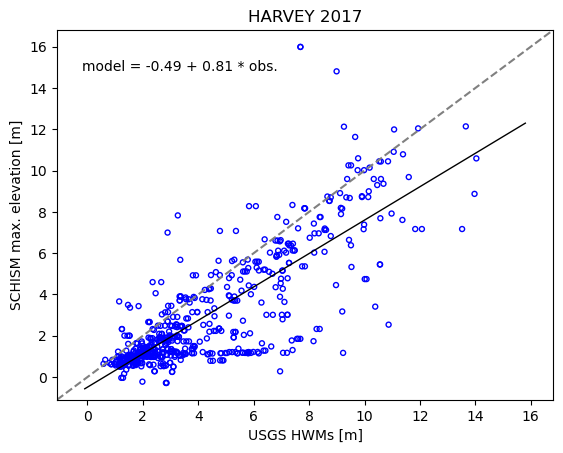

In [25]:
plot_scatter(df_hwm,storm_name,storm_year)

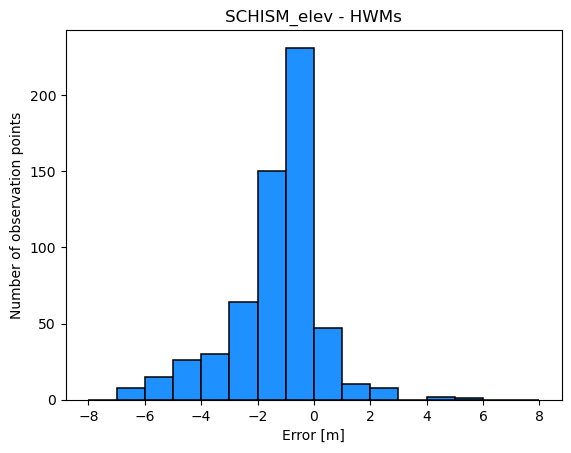

In [26]:
plot_histogram(df_hwm,storm_name,storm_year)

/tmp/ipykernel_26480/4204189309.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = plt.colorbar(


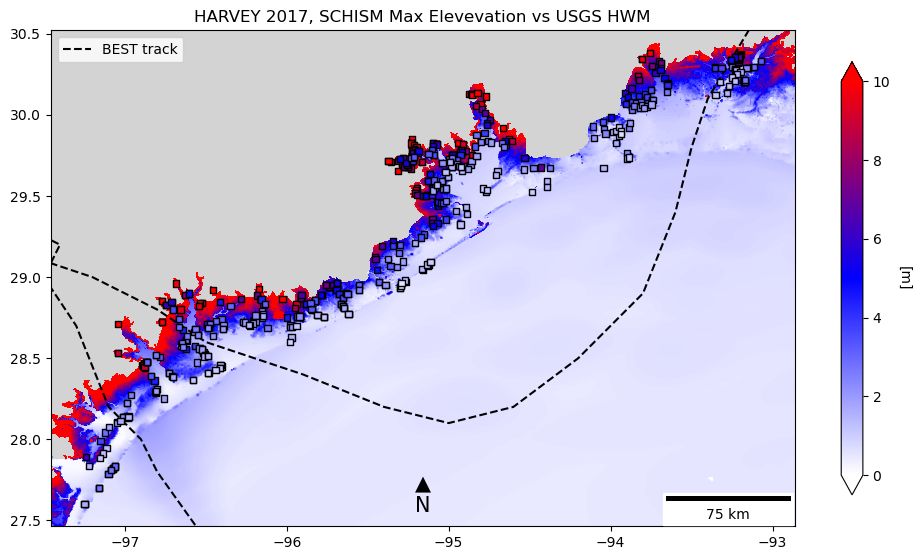

In [27]:
plot_contour(df_hwm,ds_max_elev,tri,storm_best_track)